# **Project: Monthly Sales of French Champagne**





**Statement**:

  In this problem we will try to prdict the number of monthly sales of champagne for the well-known French champagne company ***Perrin Frères***.
  The dataset is credited to **Makridakis** & **Wheelwrigt**, 1989. It describes the number of month sales of champagne from January 1964-September 1972.

The steps of this project that we will through are as follows.

* The steps:
      1. Problem Description.
      2. Test Harness.
      3. Persistence.
      4. Data Analysis.
      5. ARIMA Models.
      6. Model Validation.

In [ ]:
!pip install -U mxnet-cu101==1.7.0


In [ ]:
!nvidia-smi

In [ ]:
from mxnet import np, npx
from mxnet.gluon import nn

npx.set_np()

npx.cpu(), npx.gpu(), npx.gpu(1)

In [ ]:
npx.num_gpus() #Query the number of available gpu

# Test Harness

In [ ]:
from pandas import read_csv

series  = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

**The specific contents of these files are:**

    1. dataset.csv: Observations from January 1964 to September 1971 (93 obs)
    2. validation.csv: Observations from October 1971 to September 1972 (12 obs)

## **Model Evaluation**

In [ ]:
# evaluate persistence model on time series
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print( ' >Predicted=%.3f, Expected=%3.f ' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print( ' RMSE: %.3f ' % rmse)

*We can see that the persistence model achieved an **RMSE of 3186.501**. This means that on average, the model was wrong by about 3,186 million sales for each prediction made.*
We now a baseline prediction method and performance.

## **Data Analysis**

In [ ]:
series.describe()

In [ ]:
# Line Plot
from matplotlib import pyplot
series.plot()
pyplot.show()

The plot shows an increase trend of sales over time and appears to be systematic seasonality to the sales for each year. Therefore the seasonal signal appears to be growing over time. However we do not notice any outliers and its certainly a non-stationary series.

In [ ]:
# Seasonal Line Plots - Multiple line plots of time series
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964' : '1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
  pyplot.subplot((n_groups*100) + 10 + i)
  i += 1
  pyplot.plot(group)
pyplot.show()

In [ ]:
# density plots of time series
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

In [ ]:
# boxplots of time series
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv' , header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964' : '1970'].groupby(Grouper(freq= 'A' ))
years = DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()
pyplot.show()

# ARIMA Models

1. Manually Configure the ARIMA.
2. Automatically Configure the ARIMA.
3. Review Residual Errors.32.6. ARIMA Models

In [ ]:
# create and summarize stationary version of time series - Manual Configuration
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return Series(diff)
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print( 'ADF Statistic: %f' % result[0])
print( 'p-value: %f' % result[1])
print( 'Critical Values:' )
for key, value in result[4].items():
  print( '\t%s: %.3f' % (key, value))
# save the deseasonalized version of the series
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
pyplot.show()

The results show that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis H0 with a significance level of less than 1%. Meaning a
low probability that the result is a statistical fluke. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [ ]:
# ACF and PACF plots of time series
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

series = read_csv('stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=25, ax=pyplot.gca())
pyplot.subplot(212)

plot_pacf(series, lags=25, ax=pyplot.gca())
pyplot.show()

In [ ]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(1,1,1)) # The model can be extended to ARIMA(1,1,1)
  model_fit = model.fit(trend= 'nc', disp=0) # The trend arguments to nc
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print( '>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print( 'RMSE: %.3f' % rmse)

Note: This result in an **RMSE of 956.960** show a better improvement than the persistence RMSE of 3186.501

## Grid Search ARIMA Hyperparameters

We will search all
combinations of the following parameters:
 * p: 0 to 6
 * d: 0 to 2
 * q: 0 to 6

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    model = ARIMA(diff, order=arima_order)
    model_fit = model.fit(trend= 'nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print( 'Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

**We will select this ARIMA(4, 0, 1) model going forward.**

## Review Residual Errors

In [ ]:
# summarize ARIMA forecast residuals
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(4,0,1))
  model_fit = model.fit(trend= 'nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind= 'kde', ax=pyplot.gca())
pyplot.show()

The distribution of residual errors is also plotted. The graphs suggest a Gaussian-like distribution with a bumpy left tail, providing further evidence that perhaps a power transform might be worth exploring.

In [ ]:
# Plots of residual errors of bias corrected forecasts
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 146.401198
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(4,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind= 'kde', ax=pyplot.gca())
pyplot.show()

The performance of the predictions is improved very slightly from 911.526 to 899.693, which may or may not be significant. The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero.

In [ ]:
# ACF and PACF plots of residual errors of bias corrected forecasts
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(4,0,1))
  model_fit = model.fit(trend= 'nc' , disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

* ACF and PACF plots of residual errors on the bias corrected ARIMA model.

# Model Validation

  * Finalize Model: Train and save the final model.
  * Make Prediction: Load the finalized model and make a prediction.
  * Validate Model: Load and validate the final model.

  ## Finalize Model 

In [ ]:
# save finalized model
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(4,0,1))
model_fit = model.fit(trend= 'nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 146.401198
# save model
model_fit.save( 'model.pkl' )
numpy.save('model_bias.npy' , [bias])

   ### Make Prediction

In [ ]:
# load finalized model and make a prediction
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

## Model Validation

In [ ]:
# load and evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(4,0,1))
  model_fit = model.fit(trend= 'nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print( '>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color= 'red')
pyplot.show()

* Loading and validating the finalized model over the 12 months of forecast sales graph looks satistying.
* Therefore the plot of the expected values is represented in Blue and the predictions in Red for the validation dataset. 

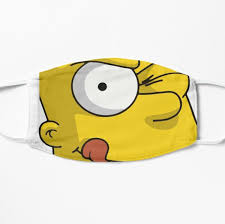